This notebook is used to create the stacked bar charts that compares the eight Gasunie scenario's over time.

In [1]:
# import packages

import numpy as np 
import pandas as pd  # provides interface for interacting with tabular data
import geopandas as gpd  # combines the capabilities of pandas and shapely for geospatial operations
from shapely.geometry import Point, Polygon, MultiPolygon  # for manipulating text data into geospatial shapes
from shapely import wkt  # stands for "well known text," allows for interchange across GIS programs
import rtree  # supports geospatial join

%matplotlib inline
import seaborn as sns
import matplotlib. pyplot as plt # for plotting graphs
import matplotlib.mlab as mlab # 
import matplotlib
plt.style.use('ggplot') # basic, but functional, plotstyle,
from matplotlib.pyplot import figure
matplotlib.rcParams['figure.figsize'] = (12,8)
import matplotlib.gridspec as GridSpec

# https://docs.bokeh.org/en/latest/docs/user_guide/categorical.html

from bokeh.io import output_file, show
from bokeh.models import ColumnDataSource, FactorRange
from bokeh.plotting import figure
from bokeh.palettes import Spectral, GnBu, PuBuGn, Set1
from bokeh.io import output_notebook
from bokeh.io import export_png

In [2]:
#scenario = 'G1'
df1 = pd.read_csv("/Users/jaromirbogdanovski/Documents/Studie/EPA/Master Thesis/Igor Nikolic/Coding/Experimentation/Input data/Municipalities_26_08_experimentation_kw G1-table.csv", header = 6, sep = ",")

#scenario = 'G2'
df2 = pd.read_csv("/Users/jaromirbogdanovski/Documents/Studie/EPA/Master Thesis/Igor Nikolic/Coding/Experimentation/Input data/Municipalities_26_08_experimentation_kw G2-table.csv", header = 6, sep = ",")

#scenario = 'G3'
df3 = pd.read_csv("/Users/jaromirbogdanovski/Documents/Studie/EPA/Master Thesis/Igor Nikolic/Coding/Experimentation/Input data/Municipalities_26_08_experimentation_kw G3-table.csv", header = 6, sep = ",")

#scenario = 'G4'
df4 = pd.read_csv("/Users/jaromirbogdanovski/Documents/Studie/EPA/Master Thesis/Igor Nikolic/Coding/Experimentation/Input data/Municipalities_26_08_experimentation_kw G4-table.csv", header = 6, sep = ",")

#scenario = 'G5'
df5 = pd.read_csv("/Users/jaromirbogdanovski/Documents/Studie/EPA/Master Thesis/Igor Nikolic/Coding/Experimentation/Input data/Municipalities_26_08_experimentation_kw G5-table.csv", header = 6, sep = ",")

#scenario = 'G6'
df6 = pd.read_csv("/Users/jaromirbogdanovski/Documents/Studie/EPA/Master Thesis/Igor Nikolic/Coding/Experimentation/Input data/Municipalities_26_08_experimentation_kw G6-table.csv", header = 6, sep = ",")

#scenario = 'G7'
df7 = pd.read_csv("/Users/jaromirbogdanovski/Documents/Studie/EPA/Master Thesis/Igor Nikolic/Coding/Experimentation/Input data/Municipalities_26_08_experimentation_kw G7-table.csv", header = 6, sep = ",")

#scenario = 'G8'
df8 = pd.read_csv("/Users/jaromirbogdanovski/Documents/Studie/EPA/Master Thesis/Igor Nikolic/Coding/Experimentation/Input data/Municipalities_26_08_experimentation_kw G8-table.csv", header = 6, sep = ",")

In [3]:
# concat dfs

df_all = pd.concat([df1.assign(scenario='G1'), df2.assign(scenario='G2'), df3.assign(scenario='G3'),
                   df4.assign(scenario='G4'), df5.assign(scenario='G5'), df6.assign(scenario='G6'),
                   df7.assign(scenario='G7'), df8.assign(scenario='G8')])

In [4]:
# melt dfs

columns = ['output-nl-ng-kw', 'output-nl-gg-kw', 'output-nl-h2-kw', 'output-nl-e-kw', 'output-nl-h-kw']
df_selected = df_all.loc[:,(columns) ].copy()
df_selected['[run number]'] = df_all['[run number]']
df_selected['[step]'] = df_all['[step]'] + 2019
df_selected['scenario'] = df_all['scenario']
df_selected = df_selected[df_selected['[step]'] > 2019]
df_selected['Methane Gas'] = df_selected['output-nl-ng-kw'] + df_selected['output-nl-gg-kw']
df_selected['All Gas'] = df_selected['output-nl-ng-kw'] + df_selected['output-nl-gg-kw'] + df_selected['output-nl-h2-kw']

df_selected = df_selected.rename(columns={"output-nl-ng-kw": "Natural_Gas", "output-nl-gg-kw": "Green_Gas", "output-nl-h2-kw": "Hydrogen_Gas", "output-nl-e-kw": "Electricity", "output-nl-h-kw": "Heat"})

df_melted = df_selected.melt(id_vars = ['[run number]', '[step]', 'scenario'], var_name = 'output_type', value_name = 'output' )
df_melted = df_melted[df_melted['[step]'] > 2019]
df_melted = df_melted.groupby(['[step]', 'scenario', 'output_type'], as_index=False).mean()
#df_melted
df_melted_pivot = df_melted.pivot(index= ['[step]', 'scenario'] , columns = 'output_type' , values = 'output')
df_melted_pivot.reset_index(drop = False, inplace = True)
df_melted_pivot = df_melted_pivot.rename(columns={'[step]': 'Year'})

df_melted_pivot['factors'] = df_melted_pivot.scenario + ', ' + df_melted_pivot['Year'].astype(str)
df_melted_pivot['factors'] = df_melted_pivot[['scenario', 'Year']].values.astype(str).tolist()

df_melted_pivot

# 100% columns



df_melted_pivot['Natural_Gas_frac'] = 100 * (df_melted_pivot['Natural_Gas'] / (df_melted_pivot['Natural_Gas'] + df_melted_pivot['Green_Gas'] + df_melted_pivot['Hydrogen_Gas'] + df_melted_pivot['Electricity'] + df_melted_pivot['Heat']))
df_melted_pivot['Green_Gas_frac'] = 100 *  (df_melted_pivot['Green_Gas'] / (df_melted_pivot['Natural_Gas'] + df_melted_pivot['Green_Gas'] + df_melted_pivot['Hydrogen_Gas'] + df_melted_pivot['Electricity'] + df_melted_pivot['Heat']))
df_melted_pivot['Hydrogen_Gas_frac'] = 100 * (df_melted_pivot['Hydrogen_Gas'] / (df_melted_pivot['Natural_Gas'] + df_melted_pivot['Green_Gas'] + df_melted_pivot['Hydrogen_Gas'] + df_melted_pivot['Electricity'] + df_melted_pivot['Heat']))
df_melted_pivot['Electricity_frac'] = 100 * (df_melted_pivot['Electricity'] / (df_melted_pivot['Natural_Gas'] + df_melted_pivot['Green_Gas'] + df_melted_pivot['Hydrogen_Gas'] + df_melted_pivot['Electricity'] + df_melted_pivot['Heat']))
df_melted_pivot['Heat_frac'] = 100 * (df_melted_pivot['Heat'] / (df_melted_pivot['Natural_Gas'] + df_melted_pivot['Green_Gas'] + df_melted_pivot['Hydrogen_Gas'] + df_melted_pivot['Electricity'] + df_melted_pivot['Heat']))
df_melted_pivot

output_type,Year,scenario,All Gas,Electricity,Green_Gas,Heat,Hydrogen_Gas,Methane Gas,Natural_Gas,factors,Natural_Gas_frac,Green_Gas_frac,Hydrogen_Gas_frac,Electricity_frac,Heat_frac
0,2020,G1,7.139181e+07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.139181e+07,7.139181e+07,"[G1, 2020]",100.000000,0.000000,0.000000,0.000000,0.000000
1,2020,G2,7.108278e+07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.108278e+07,7.108278e+07,"[G2, 2020]",100.000000,0.000000,0.000000,0.000000,0.000000
2,2020,G3,7.139181e+07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.139181e+07,7.139181e+07,"[G3, 2020]",100.000000,0.000000,0.000000,0.000000,0.000000
3,2020,G4,7.108278e+07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.108278e+07,7.108278e+07,"[G4, 2020]",100.000000,0.000000,0.000000,0.000000,0.000000
4,2020,G5,7.139181e+07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.139181e+07,7.139181e+07,"[G5, 2020]",100.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243,2050,G4,1.483276e+07,2.971846e+06,8.652292e+06,1.168454e+07,5.652369e+06,9.180393e+06,5.281008e+05,"[G4, 2050]",1.790831,29.340599,19.167626,10.077762,39.623182
244,2050,G5,1.230691e+07,9.245278e+06,7.629904e+06,2.800807e+07,0.000000e+00,1.230691e+07,4.677001e+06,"[G5, 2050]",9.437001,15.395209,0.000000,18.654624,56.513166
245,2050,G6,4.637189e+06,4.765296e+06,4.106066e+06,1.868016e+07,0.000000e+00,4.637189e+06,5.311230e+05,"[G6, 2050]",1.891286,14.621367,0.000000,16.968830,66.518517
246,2050,G7,2.117729e+07,6.599620e+06,1.649570e+07,2.354969e+07,0.000000e+00,2.117729e+07,4.681589e+06,"[G7, 2050]",9.121175,32.138690,0.000000,12.858089,45.882046


In [14]:
# https://docs.bokeh.org/en/latest/docs/user_guide/categorical.html

from bokeh.io import output_file, show
from bokeh.models import ColumnDataSource, FactorRange
from bokeh.plotting import figure
from bokeh.palettes import Spectral, RdGy

output_file("bar_stacked_grouped.html")

# subset df_stacked to only have values 2020, 2030, 2040, 2050
df_subset = df_melted_pivot[df_melted_pivot['Year'].isin([2020, 2035, 2050])].sort_values(['scenario', 'Year'])

factors = [tuple(i) for i in df_subset.factors]

#energy_output = df_rdam_melted.energy_output_type.unique() # regions


energy_output_test = ['Natural_Gas', 'Green_Gas', 'Hydrogen_Gas', 'Electricity', 'Heat']



source = ColumnDataSource(data=dict(
    x=factors,
    Natural_Gas = [df_subset['Natural_Gas'][(df_subset['scenario'] == i) & (df_subset['Year'] == int(j))].mean() for i, j in factors],
    Green_Gas = [df_subset['Green_Gas'][(df_subset['scenario'] == i) & (df_subset['Year'] == int(j))].mean() for i, j in factors],
    Hydrogen_Gas = [df_subset['Hydrogen_Gas'][(df_subset['scenario'] == i) & (df_subset['Year'] == int(j))].mean() for i, j in factors],
    Electricity = [df_subset['Electricity'][(df_subset['scenario'] == i) & (df_subset['Year'] == int(j))].mean() for i, j in factors],
    Heat = [df_subset['Heat'][(df_subset['scenario'] == i) & (df_subset['Year'] == int(j))].mean() for i, j in factors],
))

p = figure(x_range=FactorRange(*factors), toolbar_location=None, tools="")
#p = figure(plot_height=250, toolbar_location=None, tools="")

#p.vbar_stack(stackers = energy_output_test, x='x', width=0.9, alpha=0.5, color = Spectral[5], source=source, legend_label=energy_output_test)
p.vbar_stack(energy_output_test, x='x', width=0.9, alpha=0.6, color=['#bababa', '#abdda4', '#2b83ba', '#ffffbf', '#d7191c'], source=source, legend_label=energy_output_test)

p.y_range.start = 0
p.y_range.end = 100000000
p.x_range.range_padding = 0.1
p.xaxis.major_label_orientation = 1
p.xgrid.grid_line_color = None
p.legend.location = "top_center"
p.legend.orientation = "horizontal"
p.yaxis.axis_label = "Thermal Demand [kW]"
p.xaxis.axis_label = "Scenario"
p.xaxis.axis_label_text_font_size = "15pt"
p.yaxis.axis_label_text_font_size = "15pt"
p.xaxis.major_label_text_font_size = "10pt"
p.yaxis.major_label_text_font_size = "10pt"



p.width = 800
p.height = 500

output_notebook()
show(p)
#export_png(p, filename="/Users/jaromirbogdanovski/Documents/Studie/EPA/Master Thesis/Igor Nikolic/Coding/Experimentation/Output/plot.png")

Loading BokehJS ...

In [20]:
# https://docs.bokeh.org/en/latest/docs/user_guide/categorical.html

from bokeh.io import output_file, show
from bokeh.models import ColumnDataSource, FactorRange
from bokeh.plotting import figure
from bokeh.palettes import Spectral, RdGy

output_file("bar_stacked_grouped.html")

# subset df_stacked to only have values 2020, 2030, 2040, 2050
df_subset = df_melted_pivot[df_melted_pivot['Year'].isin([2020, 2035, 2050])].sort_values(['scenario', 'Year'])

factors = [tuple(i) for i in df_subset.factors]

#energy_output = df_rdam_melted.energy_output_type.unique() # regions


energy_output_test = ['Natural_Gas_frac', 'Green_Gas_frac', 'Hydrogen_Gas_frac', 'Electricity_frac', 'Heat_frac']



source = ColumnDataSource(data=dict(
    x=factors,
    Natural_Gas_frac = [df_subset['Natural_Gas_frac'][(df_subset['scenario'] == i) & (df_subset['Year'] == int(j))].mean() for i, j in factors],
    Green_Gas_frac = [df_subset['Green_Gas_frac'][(df_subset['scenario'] == i) & (df_subset['Year'] == int(j))].mean() for i, j in factors],
    Hydrogen_Gas_frac = [df_subset['Hydrogen_Gas_frac'][(df_subset['scenario'] == i) & (df_subset['Year'] == int(j))].mean() for i, j in factors],
    Electricity_frac = [df_subset['Electricity_frac'][(df_subset['scenario'] == i) & (df_subset['Year'] == int(j))].mean() for i, j in factors],
    Heat_frac = [df_subset['Heat_frac'][(df_subset['scenario'] == i) & (df_subset['Year'] == int(j))].mean() for i, j in factors],
))

p = figure(x_range=FactorRange(*factors), toolbar_location=None, tools="")
#p = figure(plot_height=250, toolbar_location=None, tools="")

#p.vbar_stack(stackers = energy_output_test, x='x', width=0.9, alpha=0.5, color = Spectral[5], source=source, legend_label=energy_output_test)
p.vbar_stack(energy_output_test, x='x', width=0.9, alpha=0.6, color=['#bababa', '#abdda4', '#2b83ba', '#ffffbf', '#d7191c'], source=source, legend_label=energy_output_test)

p.y_range.start = 0
p.y_range.end = 120
p.x_range.range_padding = 0.1
p.xaxis.major_label_orientation = 1
p.xgrid.grid_line_color = None
p.legend.location = "top_center"
p.legend.orientation = "horizontal"
p.yaxis.axis_label = "Share in total peak energy demand [%]"
p.xaxis.axis_label = "Scenario"
p.xaxis.axis_label_text_font_size = "15pt"
p.yaxis.axis_label_text_font_size = "15pt"
p.xaxis.major_label_text_font_size = "10pt"
p.yaxis.major_label_text_font_size = "10pt"



p.width = 800
p.height = 500

output_notebook()
show(p)
#export_png(p, filename="/Users/jaromirbogdanovski/Documents/Studie/EPA/Master Thesis/Igor Nikolic/Coding/Experimentation/Output/plot.png")

Loading BokehJS ...

In [5]:
df_melted

,[step],scenario,output_type,[run number],output
0,2020,G1,All Gas,50.5,7.139181e+07
1,2020,G1,Electricity,50.5,0.000000e+00
2,2020,G1,Green_Gas,50.5,0.000000e+00
3,2020,G1,Heat,50.5,0.000000e+00
4,2020,G1,Hydrogen_Gas,50.5,0.000000e+00
...,...,...,...,...,...
1731,2050,G8,Green_Gas,50.5,8.655065e+06
1732,2050,G8,Heat,50.5,1.631388e+07
1733,2050,G8,Hydrogen_Gas,50.5,0.000000e+00
1734,2050,G8,Methane Gas,50.5,9.179589e+06


In [13]:
df2035 = df_melted[df_melted['[step]'] == 2035]
df2050 = df_melted[df_melted['[step]'] == 2050]
frames = [df2035, df2050]


df_plot = pd.concat(frames)
df_plot = df_plot.rename(columns={'[step]':'Year'})
df_plot_ag_mg = df_plot[(df_plot['output_type'].str.contains('All Gas')) | (df_plot['output_type'].str.contains('Methane Gas'))]
df_plot_es = df_plot[(df_plot['output_type'].str.contains('Natural_Gas')) | (df_plot['output_type'].str.contains('Green_Gas')) | (df_plot['output_type'].str.contains('Hydrogen_Gas')) | (df_plot['output_type'].str.contains('Electricity')) | (df_plot['output_type'].str.contains('Heat'))]
df_plot_es

,Year,scenario,output_type,[run number],output
841,2035,G1,Electricity,50.5,3.995283e+06
842,2035,G1,Green_Gas,50.5,9.900450e+06
843,2035,G1,Heat,50.5,1.504111e+07
844,2035,G1,Hydrogen_Gas,50.5,0.000000e+00
846,2035,G1,Natural_Gas,50.5,3.413344e+07
...,...,...,...,...,...
1730,2050,G8,Electricity,50.5,3.465963e+06
1731,2050,G8,Green_Gas,50.5,8.655065e+06
1732,2050,G8,Heat,50.5,1.631388e+07
1733,2050,G8,Hydrogen_Gas,50.5,0.000000e+00


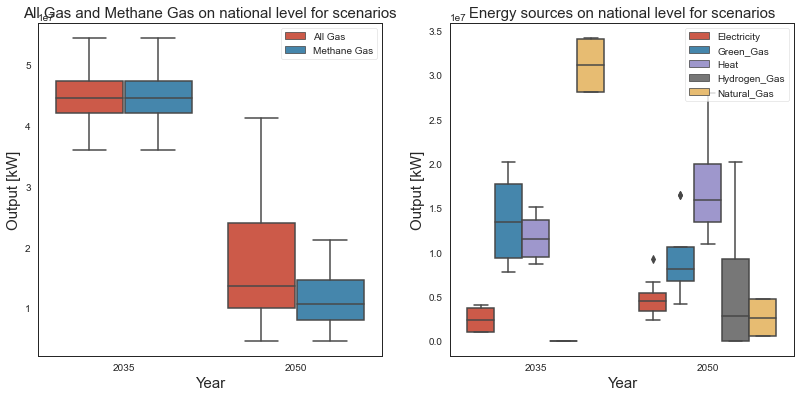

In [26]:
sns.set_style('white')
fig, (ax0, ax1) = plt.subplots(nrows = 1, ncols = 2, figsize = (12,6))
fig.tight_layout(pad=4)
#title = mr_kpi + ' MR level: Municipalities decision strategies analysis: regular vs inverse'
#fig.suptitle('Influence different strategies on MR-regions for 2035 and 2050', fontsize = 14)
sns.set_style('white')

sns.boxplot(ax=ax0, x='Year', y='output', hue = 'output_type', data = df_plot_ag_mg)
ax0.set_xlabel('Year', fontsize = 15)
ax0.set_ylabel('Output [kW]', fontsize = 15)
ax0.legend(loc='upper right', fontsize = 10)
#ax.tick_params(labelsize=10)
ax0.set_title('All Gas and Methane Gas on national level for scenarios', fontsize = 15)

sns.boxplot(ax=ax1, x='Year', y='output', hue = 'output_type', data = df_plot_es)
ax1.set_xlabel('Year', fontsize = 15)
ax1.set_ylabel('Output [kW]', fontsize = 15)
ax1.legend(loc='upper right', fontsize = 10)
ax1.set_title('Energy sources on national level for scenarios', fontsize = 15)


filepath = '/Users/jaromirbogdanovski/Documents/Studie/EPA/Master Thesis/Igor Nikolic/Coding/Experimentation/Output/'
file = filepath + 'scenarios35_50_NL'
fig.savefig(file)

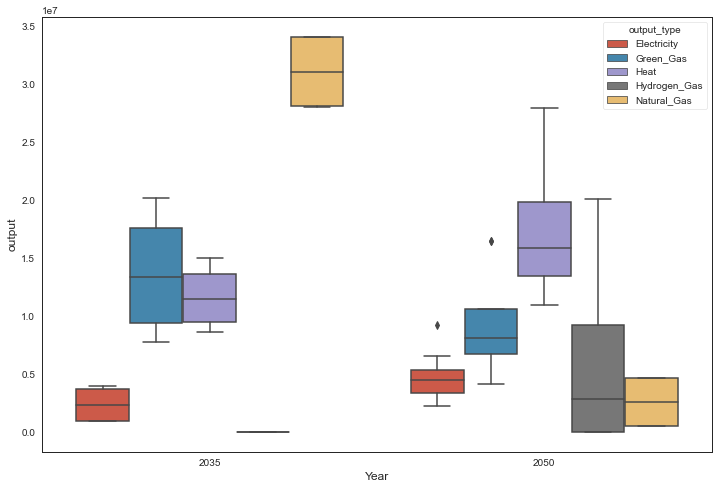

In [15]:

sns.set_style('white')


sns.boxplot(x='Year', y='output', hue = 'output_type', data = df_plot_es)
#plt.set_xlabel('Year', fontsize = 15)
#plt.set_ylabel('Output [kW]', fontsize = 15)
#plt.legend(loc='lower right', fontsize = 10)
#plt.tick_params(labelsize=10)
#ax2.set_title('Electricity', fontsize = 15)
#plt.legend([],[], frameon=False)